In [32]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt


In [86]:
## Convert csv to h5 and store
# h5 reference: https://realpython.com/fast-flexible-pandas/#selecting-data-with-isin

strava_data = pd.read_csv('raw_strava_data.csv')
# Convert data to usable things
strava_data['elapsed_time'] = pd.to_timedelta(strava_data['elapsed_time'])
            
strava_data['moving_time'] = pd.to_timedelta(strava_data['moving_time'])

strava_data['start_date_local'] = pd.to_datetime(strava_data['start_date_local'])
# Create storage object with filename `processed_data`
data_store = pd.HDFStore('strava_data.h5')

# Put DataFrame into the object setting the key as 'preprocessed_df'
data_store['strava_data'] = strava_data
data_store.close()

In [87]:
# Access data store
strava_data_h5 = pd.HDFStore('strava_data.h5')

# Retrieve data using key
strava_data = strava_data_h5['strava_data']
strava_data_h5.close()

In [88]:
morning_mask = strava_data['start_date_local'].dt.hour < 10
evening_mask = strava_data['start_date_local'].dt.hour > 13 
weekday_mask = strava_data['start_date_local'].dt.weekday < 5

In [89]:
morning_mask = strava_data['start_date_local'].dt.hour.isin(range(7, 11))
evening_mask = strava_data['start_date_local'].dt.hour.isin(range(14, 20))
weekday_mask = strava_data['start_date_local'].dt.weekday.isin(range(0, 5))

In [90]:
morning_commutes = strava_data[morning_mask & weekday_mask]
evening_commutes = strava_data[evening_mask & weekday_mask]

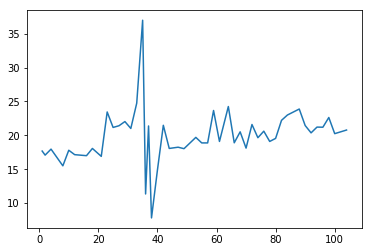

In [91]:
(evening_commutes['moving_time'] / pd.Timedelta(minutes=1)).plot()
plt.show()

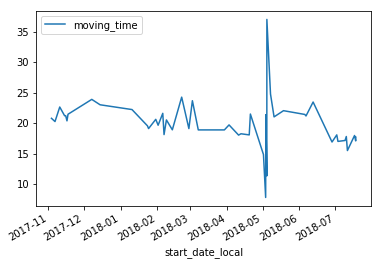

In [92]:
to_plot = evening_commutes.copy()
to_plot['moving_time'] = to_plot.loc[:,'moving_time'] / pd.Timedelta(minutes=1)
to_plot.plot(x='start_date_local', y='moving_time')
plt.show()